In [44]:
"""
XGBoost multiclassifier for roof materials in D.C.
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import optuna
import gc

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [2]:
results_dir = os.path.join(homedir, 'OPP/results/xgboost-cv/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/


In [3]:
# Load the image data

In [4]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/dc/dc_0623_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")
del stack_da

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [5]:
# Load the reference data

In [6]:
# Load the training data (footprints)
# ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints_sampled.gpkg')
ref_fp = os.path.join(homedir,'OPP/training/dc/dc_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,-0.246291,0.373826,0.472331,0.204085,0.080244,2.598158,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,-0.856021,0.632535,1.064584,1.001515,0.569262,0.367447,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,-0.864054,0.813552,0.806408,0.734980,0.218044,-0.683204,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,-0.735984,0.305262,0.856115,0.508690,0.070037,0.680645,"POLYGON ((333608.130 4306267.691, 333607.957 4..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,-0.418819,0.516599,0.897064,0.448048,0.185206,-0.394834,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [7]:
print(ref['class_code'].value_counts())

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64


In [8]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])

# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))

print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [9]:
# Create a holdout sample for model evaluation later on

In [10]:
# Create the holdout data (independent from model training in CV)
holdout_fraction = 0.20 # excluding 20% of the data for holdout/independent testing
train_df, holdout_df, _ = split_training_data(ref, ts=holdout_fraction, vs=None) # no validation needed yet

print("Training set class distribution:\n", train_df[['class_code','code']].value_counts())
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Training set class distribution:
 class_code  code
CS          0       29706
ME          1       29491
SL          2       12213
UR          3        1023
WS          5         921
TL          4         739
SH          6         626
Name: count, dtype: int64
Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [11]:
# Parameter tuning using Optuna

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(train_df['code'])),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 101, 1001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1.0),
        'random_state': 44
    }

    # Stratified 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    
    f1_scores = [] # to store the validation F1 for each fold
    
    for train_idx, val_idx in skf.split(train_df, train_df['class_code']):
        # Extract the train and validation sets
        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]

        # Undersample majority class in training set only
        fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

        # Calculate the class weights
        val_counts = fold_train_bal['code'].value_counts()
        total_samples = sum(val_counts)
        class_weights = np.array([total_samples / count for count in val_counts])
        class_weights_n = class_weights / class_weights.sum() # normalize the weights
        class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

        # Define our train/validation sets
        X_train = fold_train_bal[band_names].astype(float)
        y_train = fold_train_bal['code'].astype(int)
        X_val = fold_val[band_names].astype(float)
        y_val = fold_val['code'].astype(int)
        
        del fold_train, fold_val, fold_train_bal # clear up space

        # Fit the XGBoost with params
        xgb_model = xgb.XGBClassifier(n_jobs=1, **params) # avoid over-using CPU resources
        xgb_model.fit(
            X_train, y_train,
            sample_weight=y_train.map(class_weights_n).values,
            verbose=False
        )

        # Evaluate F1-score on the validation set
        y_pred = xgb_model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

        del y_pred, f1, X_train, y_train, X_val, y_val, xgb_model

    # Calculate mean metrics across folds
    f1_ = np.mean(f1_scores)

    del f1_scores
    gc.collect()

    return f1_  # Optuna will maximize this score

print("Optuna function ready to go !!!")

Optuna function ready to go !!!


In [14]:
t0 = time.time()

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Implement the optuna objective study
study = optuna.create_study(direction='maximize', study_name='dc_xgboost_tuning') # maximize the scoring criteria
study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)  # Adjust the number of trials as needed
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters found: {best_params}")
# Save the Optuna study for later analysis
study.trials_dataframe().to_csv(os.path.join(results_dir, 'dc-xgboost-cv_optuna_trials.csv'), index=False)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time for 100 trials: {t2:.2f} minutes.")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



  0%|          | 0/200 [00:00<?, ?it/s]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Best hyperparameters found: {'learning_rate': 0.00919373106215862, 'max_depth': 12, 'n_estimators': 925, 'min_child_weight': 4, 'subsample': 0.6852892603656635, 'colsample_bytree': 0.5455821649652058, 'gamma': 1.0321616783434356e-05}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Total elapsed time for 100 trials: 15.00 minutes.


In [ ]:
best_params

In [ ]:
# Model run w/ best parameters

In [ ]:
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

In [22]:
t0 = time.time()

# Define dataframes to store results for this feature set
results = pd.DataFrame()  # to store the model performance metrics

# Set up the stratified K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=44)

# Loop the folds
fold_idx = 1
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class_code'])):
    t00 = time.time()
    
    print(f"Processing fold {fold_idx + 1}/{n_folds}...")

    # Get the train and validation splits for this fold
    fold_train = train_df.iloc[train_idx]
    fold_val = train_df.iloc[val_idx]

    # Apply random undersampling to the training data within this fold
    fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

    print(f"Train class distribution (fold {fold_idx + 1}):\n", fold_train_bal['code'].value_counts().to_dict())
    print(f"Validation class distribution (fold {fold_idx + 1}):\n", fold_val['code'].value_counts().to_dict())

    # Calculate the class weights
    val_counts = fold_train_bal['code'].value_counts()
    total_samples = sum(val_counts)
    class_weights = np.array([total_samples / count for count in val_counts])
    class_weights_n = class_weights / class_weights.sum() # normalize the weights
    class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(fold_train_bal['code'])),
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
        early_stopping_rounds=100, # stop if no improvement
        random_state=44
    )

    #################
    # Fit the model #

    # Defin train/validation/holdout sets
    X_train = fold_train_bal[band_names].astype(float)
    y_train = fold_train_bal['code'].astype(int)
    X_val = fold_val[band_names].astype(float)
    y_val = fold_val['code'].astype(int)
    X_test = holdout_df[band_names].astype(float)
    y_test = holdout_df['code'].astype(int)

    # Define our evaluation sets
    eval_set = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

    xgb_model.fit(
        X_train, y_train,
        eval_set=eval_set,  # Specify train/validation/holdout sets for evaluation
        sample_weight=y_train.map(class_weights_n).values,
        verbose=False
    )

    # Retrieve the evaluation metrics for the fold
    eval_results = xgb_model.evals_result()
    
    # Extract the evaluation metrics for each set
    mlogloss_train = eval_results['validation_0']['mlogloss']
    auc_train = eval_results['validation_0']['auc']
    error_train = eval_results['validation_0']['merror']
    
    mlogloss_val = eval_results['validation_1']['mlogloss']
    auc_val = eval_results['validation_1']['auc']
    error_val = eval_results['validation_1']['merror']

    mlogloss_test = eval_results['validation_2']['mlogloss']
    auc_test = eval_results['validation_2']['auc']
    error_test = eval_results['validation_2']['merror']

    ##################################################
    # Make prediction on validation and holdout sets #
    
    # Predict on the validation set
    y_pred = xgb_model.predict(X_val)
    # Calculate the validation  accuracy and f1-score (weighted)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    acc_val = accuracy_score(y_val, y_pred)

    print(f"\tFold [{fold_idx}] accuracy: {acc_val:.3f};\n\tF1-score: {f1_val:.3f};")

    # Make predictions on the holdout data
    y_test_pred = xgb_model.predict(X_test)
    # Calculate the holdout accuracy and f1-score (weighted)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)

    # Also store the predicted probabilites for AUCPR
    y_test_pred_probs = xgb_model.predict_proba(X_test)
    
    print(f"\tFold [{fold_idx}] Holdout accuracy: {acc_test:.3f};\n\tHoldout F1-score: {f1_test:.3f}")

    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'fold': [fold_idx],
        'f1_val': [f1_val],
        'acc_val': [acc_val],
        'val_labs': [y_val.tolist()],
        'val_preds': [y_pred.tolist()],
        'f1_test': [f1_test],
        'acc_test': [acc_test],
        'test_labs': [y_test.tolist()],
        'test_preds': [y_test_pred.tolist()],
        'test_preds_probs': [y_test_pred_probs.tolist()],
        'mlogloss_train': [mlogloss_train],
        'mlogloss_val': [mlogloss_val],
        'mlogloss_test': [mlogloss_test],
        'auc_train': [auc_train],
        'auc_val': [auc_val],
        'auc_test': [auc_test],
        'merror_train': [error_train],
        'merror_val': [error_val],
        'merror_test': [error_test]
    })
    
    # Concatenate with the results data frame
    results = pd.concat([results, fold_results], ignore_index=True)

    # Save the model for further evaluation
    model_fn = f"dc-xgb_fold{fold_idx + 1}.model"
    xgb_model.save_model(os.path.join(results_dir, model_fn))

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")

    del X_train, y_train, X_val, y_val, y_pred, val_counts, total_samples, class_weights, fold_train # clean up some
    gc.collect()

    print("\n~~~~~~~~~~\n")

# Save the results dataframe
results.to_csv(os.path.join(results_dir, 'dc-xgboost-cv_results.csv'))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Processing fold 1/5...
Train class distribution (fold 1):
 {0: 2505, 1: 2505, 2: 2505, 3: 818, 5: 737, 4: 591, 6: 501}
Validation class distribution (fold 1):
 {0: 5942, 1: 5898, 2: 2442, 3: 205, 5: 184, 4: 148, 6: 125}
	Fold [0] accuracy: 0.576;
	F1-score: 0.606;
	Fold [0] Holdout accuracy: 0.579;
	Holdout F1-score: 0.609
Total elapsed time for fold 0: 1.16 minutes.

~~~~~~~~~~

Processing fold 2/5...
Train class distribution (fold 2):
 {0: 2505, 1: 2505, 2: 2505, 3: 818, 5: 737, 4: 591, 6: 501}
Validation class distribution (fold 2):
 {0: 5941, 1: 5899, 2: 2442, 3: 205, 5: 184, 4: 148, 6: 125}
	Fold [1] accuracy: 0.578;
	F1-score: 0.610;
	Fold [1] Holdout accuracy: 0.579;
	Holdout F1-score: 0.609
Total elapsed time for fold 1: 1.04 minutes.

~~~~~~~~~~

Processing fold 3/5...
Train class distribution (fold 3):
 {0: 2505, 1: 2505, 2: 2505, 3: 818, 5: 736, 4: 592, 6: 501}
Validation class distribution (fold 3):
 {0: 5941, 1: 5898, 2: 2443, 3: 205, 5: 185, 4: 147, 6: 125}
	Fold [2] accu

In [23]:
results.head()

,fold,f1_val,acc_val,val_labs,val_preds,f1_test,acc_test,test_labs,test_preds,test_preds_probs,mlogloss_train,mlogloss_val,mlogloss_test,auc_train,auc_val,auc_test,merror_train,merror_val,merror_test
0,0,0.606028,0.575816,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 2, 0, 1, ...",0.608976,0.578868,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 4, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 0, ...","[[0.452174574136734, 0.039807114750146866, 0.0...","[1.9362704095303649, 1.92701741756827, 1.91756...","[1.9398121687501861, 1.9341854524481603, 1.928...","[1.9398369766663721, 1.934345944206088, 1.9286...","[0.8537707969204309, 0.8991800303524348, 0.919...","[0.756020964178975, 0.7918700900485554, 0.8046...","[0.7552601781123002, 0.7867398849538354, 0.800...","[0.4716591222200354, 0.38171619759889786, 0.33...","[0.6353720556745182, 0.6127542826552462, 0.583...","[0.6425092329925601, 0.6123213616656854, 0.582..."
1,1,0.609535,0.577623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 2, 2, 0, 2, 2, 3, 0, 2, 5, 0, 2, 2, 0, 0, ...",0.608691,0.579404,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 1, 6, 0, 2, 0, 2, 0, 1, 2, 2, ...","[[0.5723424553871155, 0.030123217031359673, 0....","[1.9365489122506743, 1.926892850406525, 1.9173...","[1.9402354823094363, 1.9346406288460951, 1.928...","[1.9400465508532818, 1.934569586543948, 1.9286...","[0.8550180171341617, 0.9012595672468895, 0.919...","[0.7627704868004407, 0.7919848066789822, 0.803...","[0.7646593653649694, 0.790106841878178, 0.8046...","[0.4791379649675261, 0.3863412714032671, 0.332...","[0.6585920770877944, 0.625669164882227, 0.5933...","[0.6533747256864529, 0.6258095594925869, 0.589..."
2,2,0.612055,0.584449,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 0, 5, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 5, 0, ...",0.611935,0.582829,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.4183221459388733, 0.07195653766393661, 0.1...","[1.936165006323561, 1.9266446115134903, 1.9172...","[1.9397730982485497, 1.9343148137600314, 1.928...","[1.9396216838599616, 1.9341307594364858, 1.928...","[0.8534021519343656, 0.899904858652156, 0.9181...","[0.7585088965885721, 0.7856573432343568, 0.800...","[0.7620385939988967, 0.7890149299744788, 0.802...","[0.474414485337532, 0.3874237354851407, 0.3329...","[0.6474839400428265, 0.6135572805139187, 0.587...","[0.6432050527217257, 0.614676443825938, 0.5850..."
3,3,0.610076,0.581839,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 0, 2, 0, 2, 5, 0, 2, 0, 0, 0, 0, 2, 0, 0, ...",0.612069,0.584328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 2, ...","[[0.42453449964523315, 0.033438630402088165, 0...","[1.9357511693883602, 1.9262269109038164, 1.916...","[1.9395588792349976, 1.933916515724562, 1.9280...","[1.939648352113148, 1.933843786141056, 1.92793...","[0.8603250202110219, 0.9028100137506773, 0.922...","[0.7581610494467199, 0.7908175532144314, 0.803...","[0.7586426159371022, 0.790811079324146, 0.8043...","[0.46082585986005714, 0.37695870700699713, 0.3...","[0.6271413276231264, 0.5987687366167024, 0.571...","[0.6335706257025103, 0.6011882459990365, 0.569..."
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...","[1.9360677208192445, 1.9264164314511183, 1.916...","[1.9398103787351275, 1.9341640938303999, 1.928...","[1.939779382749179, 1.934226293357876, 1.92816...","[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.64079644

In [ ]:
# Plot the 'mlogloss' across folds

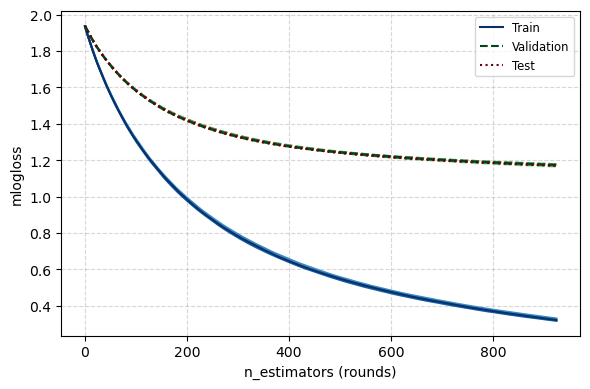

In [26]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = results[results['fold'] == fold_idx]
          
    mlogloss_train = fold_data['mlogloss_train'].iloc[0]  # List of mlogloss for training set
    mlogloss_val = fold_data['mlogloss_val'].iloc[0]      # List of mlogloss for validation set
    mlogloss_test = fold_data['mlogloss_test'].iloc[0]  

    # Plot the mlogloss across epochs
    plt.plot(mlogloss_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(mlogloss_val, color=colors_val[idx], linestyle='--', label=f'Validation')
    plt.plot(mlogloss_test, color=colors_test[idx], linestyle=':', label=f'Test')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('mlogloss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_mlogloss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Multiclass error across folds

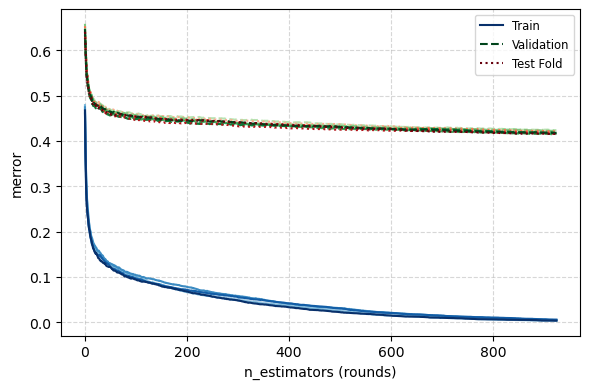

In [27]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = results[results['fold'] == fold_idx]
          
    merror_train = fold_data['merror_train'].iloc[0]  
    merror_val = fold_data['merror_val'].iloc[0]      
    merror_test = fold_data['merror_test'].iloc[0]  

    # Plot the mlogloss across epochs
    plt.plot(merror_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(merror_val, color=colors_val[idx], linestyle='--', label=f'Validation')
    plt.plot(merror_test, color=colors_test[idx], linestyle=':', label=f'Test Fold')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_merror.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Model AUC across folds

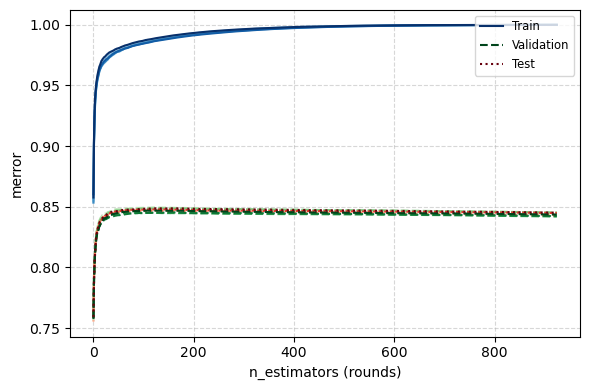

In [29]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = results[results['fold'] == fold_idx]
          
    auc_train = fold_data['auc_train'].iloc[0]  
    auc_val = fold_data['auc_val'].iloc[0]      
    auc_test = fold_data['auc_test'].iloc[0]  

    # Plot the mlogloss across epochs
    plt.plot(auc_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(auc_val, color=colors_val[idx], linestyle='--', label=f'Validation')
    plt.plot(auc_test, color=colors_test[idx], linestyle=':', label=f'Test')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_auc.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Bar chart of correct against true

In [34]:
code_mapping = dict(zip(ref['code'], ref['class_code']))
print(code_mapping)

{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WS', 6: 'SH'}


In [ ]:
results['true_class_code'] = results['test_labs'].apply(lambda x: [code_mapping[code] for code in x])
results['pred_class_code'] = results['test_preds'].apply(lambda x: [code_mapping[pred] for pred in x])
print(results.head())

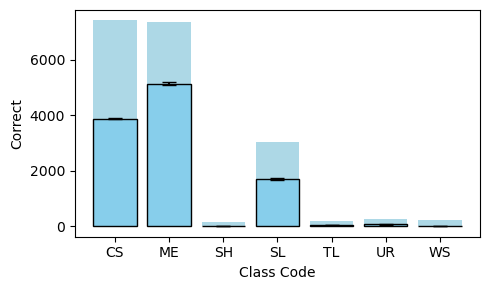

In [41]:
# Create a DataFrame for plotting correct predictions by class code across folds

results_exp = results.explode(['true_class_code', 'pred_class_code'])
results_exp['correct'] = results_exp['true_class_code'] == results_exp['pred_class_code']

preds_df_correct = results_exp.groupby(['fold', 'true_class_code']).agg(correct_count=('correct', 'sum')).reset_index()
preds_df_correct = preds_df_correct.groupby('true_class_code')['correct_count'].agg(['mean', 'std']).reset_index()

# Get total counts of true labels
total_counts = results_exp.groupby(['fold', 'true_class_code']).size().reset_index(name='total_count')
total_counts_mn = total_counts.groupby('true_class_code')['total_count'].mean().reset_index()

# Merge back to data frame
preds_df_correct = preds_df_correct.merge(total_counts_mn, on='true_class_code', how='left')

plt.figure(figsize=(5, 3))

plt.bar(preds_df_correct['true_class_code'], preds_df_correct['total_count'], color='lightblue', label='Total Samples')
plt.bar(preds_df_correct['true_class_code'], preds_df_correct['mean'], yerr=preds_df_correct['std'], 
        capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('Correct')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_correct_preds.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Generate the classification reports

In [46]:
all_reports = [] # to store the classification reports for each fold
class_codes = list(results_exp['true_class_code'].unique())
print(class_codes)

# Iterate over the folds
for fold_idx in results['fold'].unique():
    print(f"Create CR for fold [{fold_idx}]")

    fold_preds_df = results_exp[results_exp['fold'] == fold_idx]

    print(fold_preds_df.correct.value_counts())
    
    # Gather the true and predicted labels
    true_labs_fold = fold_preds_df['true_class_code']
    pred_labs_fold = fold_preds_df['pred_class_code']

    # Generate the classification report
    cr_fold = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
    cr_fold['fold_idx'] = fold_idx
    cr_fold = cr_fold.reset_index().rename(columns={'index': 'class_code'})
    cr_fold = cr_fold[cr_fold['class_code'].isin(class_codes)] # keep only the per class metrics (i.e., not the weighted average)
    all_reports.append(cr_fold)

# Combine the reports
cr_df = pd.concat(all_reports, axis=0)

# Save the report as a CSV
cr_df.to_csv(os.path.join(results_dir, 'dc-xgboost-cv_classification_reports.csv'))
print(cr_df)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']
Create CR for fold [0]
correct
True     10815
False     7868
Name: count, dtype: int64
Create CR for fold [1]
correct
True     10825
False     7858
Name: count, dtype: int64
Create CR for fold [2]
correct
True     10889
False     7794
Name: count, dtype: int64
Create CR for fold [3]
correct
True     10917
False     7766
Name: count, dtype: int64
Create CR for fold [4]
correct
True     10922
False     7761
Name: count, dtype: int64
  class_code  precision    recall  f1-score  support  fold_idx
0         CS   0.707348  0.519725  0.599193   7427.0         0
1         ME   0.806238  0.694154  0.746010   7373.0         0
2         SH   0.027972  0.025478  0.026667    157.0         0
3         SL   0.369575  0.557629  0.444531   3054.0         0
4         TL   0.129032  0.216216  0.161616    185.0         0
5         UR   0.061277  0.281250  0.100629    256.0         0
6         WS   0.028037  0.077922  0.041237    231.0         0
0         CS   0.7

In [47]:
# Calculate the mean metrics across all folds
cr_summary = cr_df[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                      'recall', 'recall_sd', 
                      'f1-score', 'f1-score_sd']
cr_summary

,class_code,precision,precision_sd,recall,recall_sd,f1-score,f1-score_sd
0,CS,0.708763,0.004315,0.522391,0.003209,0.601462,0.002686
1,ME,0.804528,0.003491,0.698142,0.007295,0.747546,0.004003
2,SH,0.014660,0.016399,0.011465,0.013053,0.012814,0.014434
3,SL,0.371678,0.003262,0.560052,0.006828,0.446809,0.003627
4,TL,0.135800,0.020234,0.228108,0.020369,0.170046,0.020881
5,UR,0.059811,0.001739,0.275781,0.010186,0.098291,0.002770
6,WS,0.035847,0.005154,0.092641,0.011289,0.051654,0.006946


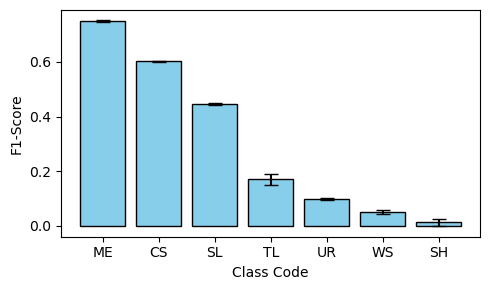

In [48]:
cr_summary = cr_summary.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(5, 3))
plt.bar(cr_summary['class_code'], cr_summary['f1-score'], 
        yerr=cr_summary['f1-score_sd'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('F1-Score')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_mean_f1-score_bar.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Identify the best model from the folds

In [49]:
f1_scores_wt = [] # to store the weighted f1-scores
for fold_idx in cr_df['fold_idx'].unique():
    # Filter data for the current fold
    fold_data = cr_df[cr_df['fold_idx'] == fold_idx]
    
    # Calculate the weighted F1-score for this fold
    total_support = fold_data['support'].sum()
    weighted_f1 = (fold_data['f1-score'] * fold_data['support']).sum() / total_support
    
    # Append the results
    f1_scores_wt.append({'fold_idx': fold_idx, 'weighted_f1_score': weighted_f1})

# Convert to a DataFrame
f1_scores_wt_df = pd.DataFrame(f1_scores_wt)

# Identify the best-performing fold
best_fold = f1_scores_wt_df.loc[f1_scores_wt_df['weighted_f1_score'].idxmax()]
print(f"Best performing fold is Fold {int(best_fold['fold_idx'])} with a weighted F1-score of {best_fold['weighted_f1_score']:.4f}")

Best performing fold is Fold 4 with a weighted F1-score of 0.6129


In [53]:
best_fold_df = results_exp[results_exp['fold'] == int(best_fold['fold_idx'])]
best_fold_df.head()

,fold,f1_val,acc_val,val_labs,val_preds,f1_test,acc_test,test_labs,test_preds,test_preds_probs,...,auc_train,auc_val,auc_test,merror_train,merror_val,merror_test,correct,class_code,true_class_code,pred_class_code
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...",...,"[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.6407964459669218, 0.6117861157201734, 0.569...",True,"[CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, C...",CS,CS
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...",...,"[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.6407964459669218, 0.6117861157201734, 0.569...",False,"[CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, C...",CS,SL
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...",...,"[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.6407964459669218, 0.6117861157201734, 0.569...",True,"[CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, C...",CS,CS
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...",...,"[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.6407964459669218, 0.6117861157201734, 0.569...",True,"[CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, C...",CS,CS
4,4,0.611476,0.582145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 0, 1, 2, 0, 5, 0, 0, 5, 0, 2, 0, 0, 2, ...",0.612934,0.584596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[[0.645300030708313, 0.047969672828912735, 0.0...",...,"[0.8576601371765847, 0.9037219678229387, 0.925...","[0.7575979532753786, 0.7860801203076377, 0.799...","[0.7593233645312963, 0.7851453861425021, 0.799...","[0.4675784709239398, 0.37183902391026274, 0.30...","[0.6469249815967343, 0.6106538178411296, 0.571...","[0.6407964459669218, 0.6117861157201734, 0.569...",False,"[CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, CS, C...",CS,SL


In [54]:
# Gather the report for the best model

# Gather the true and predicted labels
true_labs_fold = best_fold_df['true_class_code']
pred_labs_fold = best_fold_df['pred_class_code']

# Generate the classification report
cr_best = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
print(cr_best)

              precision    recall  f1-score       support
CS             0.713477  0.526054  0.605596   7427.000000
ME             0.799537  0.702157  0.747689   7373.000000
SH             0.035714  0.025478  0.029740    157.000000
SL             0.372691  0.555010  0.445935   3054.000000
TL             0.171429  0.259459  0.206452    185.000000
UR             0.059564  0.277344  0.098066    256.000000
WS             0.033333  0.086580  0.048135    231.000000
accuracy       0.584596  0.584596  0.584596      0.584596
macro avg      0.312249  0.347440  0.311659  18683.000000
weighted avg   0.663301  0.584596  0.612934  18683.000000


In [ ]:
# Generate confusion matrices

In [55]:
class_names = list(code_mapping.values())
print(class_names)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']


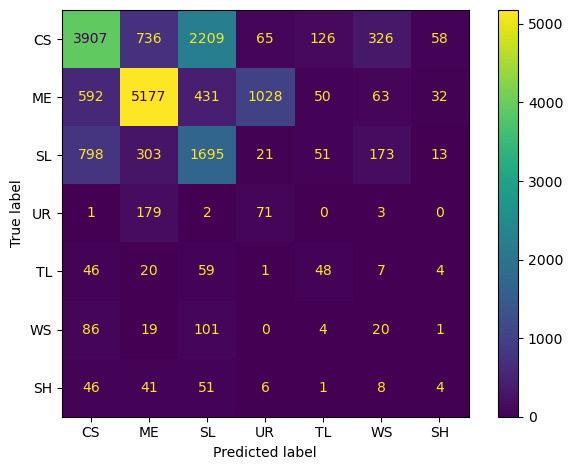

In [56]:
# For the best performing model (Fold 2)
cm_best = confusion_matrix(
    best_fold_df['true_class_code'], 
    best_fold_df['pred_class_code'], 
    labels=class_names)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names)
disp.plot(cmap='viridis')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_confusion_matrix_bestFold.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

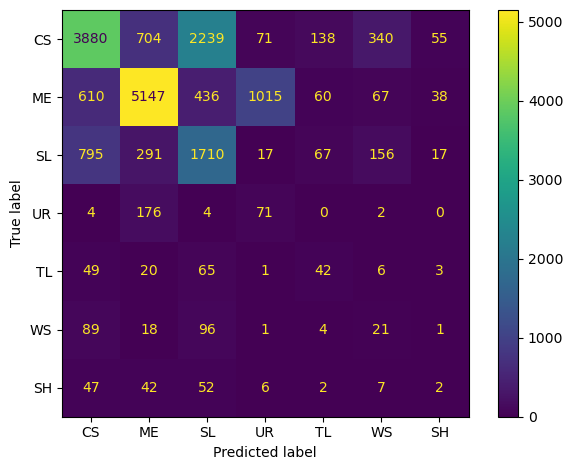

In [58]:
average_cm = np.zeros((len(class_names), len(class_names)))

# Iterate through each fold and accumulate the confusion matrix
for fold_idx in results_exp['fold'].unique():
    fold_preds = results_exp[results_exp['fold'] == fold_idx]
    cm_fold = confusion_matrix(
        fold_preds['true_class_code'], 
        fold_preds['pred_class_code'], 
        labels=class_names
    )
    average_cm += cm_fold

# Divide by the number of folds to get the average
average_cm /= len(results_exp['fold'].unique())
average_cm = np.rint(average_cm).astype(int)

# Plot the confusion matrix
disp_avg = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=class_names)
disp_avg.plot(cmap='viridis', values_format='d')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/dc-xgboost-cv_confusion_matrix_average.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

In [ ]:
# Calculate the per-class AUC-PR

In [61]:
from sklearn.metrics import precision_recall_curve, auc

# Initialize an empty dictionary to store AUCPR values
auprc_per_fold = {}

# Loop through each fold
for fold_idx in range(n_folds):
    # Extract data for the current fold
    fold_data = results[results['fold'] == fold_idx]

    # Retrieve the true labels and predicted probabilities
    y_true = np.array(fold_data['test_labs'].iloc[0])  # The true labels
    y_pred_probs = np.array(fold_data['test_preds_probs'].iloc[0])  # Predicted probabilities

    # Initialize a dictionary to store AUCPR for the current fold
    auprc_fold = {}

    # Calculate AUCPR for each class
    num_classes = y_pred_probs.shape[1]  # Get the number of classes
    for class_idx in range(num_classes):
        # Extract true labels for the current class (binary, 1 if true, 0 otherwise)
        y_true_binary = (y_true == class_idx).astype(int)
        
        # Extract predicted probabilities for the current class
        y_scores = y_pred_probs[:, class_idx]

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)

        # Calculate AUCPR
        auc_pr = auc(recall, precision)
        
        # Store the result for this class
        auprc_fold[class_idx] = auc_pr

    # Store the per-class AUCPR for this fold
    auprc_per_fold[fold_idx] = auprc_fold

# Convert the AUCPR results to a DataFrame for easy analysis
auprc_df = pd.DataFrame(auprc_per_fold).T
auprc_df.columns = [f'Class {i} AUCPR' for i in range(num_classes)]
auprc_df.index.name = 'Fold'

# Display the per-fold, per-class AUCPR
auprc_df

# # Save the AUCPR results to a CSV file
# auprc_df.to_csv(os.path.join(results_dir, 'dc-xgboost-cv_auprc_results.csv'))

,Class 0 AUCPR,Class 1 AUCPR,Class 2 AUCPR,Class 3 AUCPR,Class 4 AUCPR,Class 5 AUCPR,Class 6 AUCPR
Fold,,,,,,,
0,0.712451,0.821510,0.377789,0.059550,0.113691,0.025961,0.011498
1,0.714161,0.822884,0.369207,0.048551,0.119075,0.025973,0.010406
2,0.720060,0.823079,0.373799,0.050446,0.115644,0.026831,0.010734
3,0.718062,0.825271,0.364897,0.051629,0.115350,0.028870,0.010496
4,0.721284,0.824827,0.373155,0.057905,0.126778,0.027126,0.013363


In [62]:
gc.collect()

3182